In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
from sklearn import preprocessing
from lightfm import LightFM
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix 
from sklearn.metrics import roc_auc_score
import time
from lightfm.evaluation import auc_score
import pickle
import re
import seaborn as sns

In [2]:
# Items/Books Data
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

# Users Data
users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

#Rating Data
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [3]:
ratings.shape

(1149780, 3)

In [4]:
books.shape


(271360, 8)

In [5]:
users.shape 

(278858, 3)

In [6]:
ratings.head()


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
books.head()


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [9]:
books.columns

Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'imageUrlS', 'imageUrlM', 'imageUrlL'],
      dtype='object')

In [10]:
#books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)
del books['imageUrlS']
del books['imageUrlM']
del books['imageUrlL']
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)

In [11]:
books.columns

Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher'], dtype='object')

In [12]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings = ratings[ratings.userID.isin(users.userID)]
ratings_explicit = ratings_new[ratings_new.bookRating != 0]

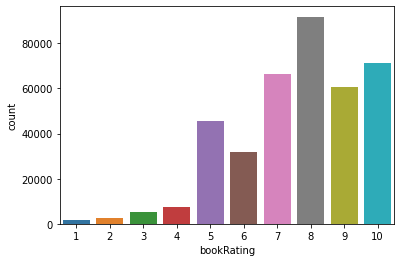

In [13]:
sns.countplot(data=ratings_explicit, x='bookRating')
plt.show()


In [14]:
# Making a Threshold for Book and User i.e only Users who rates more than 20 Books and Books that already rated by 20 Users
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 20].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 20].index)]

ratings_explicit.shape

(217729, 3)

In [15]:
def informed_train_test(rating_df, train_ratio):
    split_cut = np.int(np.round(rating_df.shape[0] * train_ratio))
    train_df = rating_df.iloc[0:split_cut]
    test_df = rating_df.iloc[split_cut::]
    test_df = test_df[(test_df['userID'].isin(train_df['userID'])) & (test_df['ISBN'].isin(train_df['ISBN']))]
    id_cols = ['userID', 'ISBN']
    trans_cat_train = dict()
    trans_cat_test = dict()
    for k in id_cols:
        cate_enc = preprocessing.LabelEncoder()
        trans_cat_train[k] = cate_enc.fit_transform(train_df[k].values)
        trans_cat_test[k] = cate_enc.transform(test_df[k].values)

# --- Encode ratings:
    cate_enc = preprocessing.LabelEncoder()
    ratings = dict()
    ratings['train'] = cate_enc.fit_transform(train_df.bookRating)
    ratings['test'] = cate_enc.transform(test_df.bookRating)
    n_users = len(np.unique(trans_cat_train['userID']))
    n_items = len(np.unique(trans_cat_train['ISBN']))
    train = coo_matrix((ratings['train'], (trans_cat_train['userID'], trans_cat_train['ISBN'])), shape=(n_users, n_items))
    test = coo_matrix((ratings['test'], (trans_cat_test['userID'], trans_cat_test['ISBN'])), shape=(n_users, n_items))
    return train, test, train_df


In [16]:
print('hello')

hello


In [17]:
train, test, raw_train_df = informed_train_test(ratings_explicit, 0.8)
start_time = time.time()
model=LightFM(no_components=110,learning_rate=0.027,loss='warp')
model.fit(train,epochs=12,num_threads=4)
# with open('saved_model','wb') as f:
#     saved_model={'model':model}
#     pickle.dump(saved_model, f)
auc_train = auc_score(model, train).mean()
auc_test = auc_score(model, test).mean()
print("--- Run time:  {} mins ---".format((time.time() - start_time)/60))
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

--- Run time:  1.5082500298817954 mins ---
Train AUC Score: 0.9762868285179138
Test AUC Score: 0.840415358543396


In [18]:
import scipy.sparse as sp
def _shuffle(uids, iids, data, random_state):
    shuffle_indices = np.arange(len(uids))
    random_state.shuffle(shuffle_indices)
    return (uids[shuffle_indices], iids[shuffle_indices], data[shuffle_indices])

def random_train_test_split(interactions_df, test_percentage=0.25,random_state=None):
    """
    Randomly split interactions between training and testing.
This function takes an interaction set and splits it into
    two disjoint sets, a training set and a test set. Note that
    no effort is made to make sure that all items and users with
    interactions in the test set also have interactions in the
    training set; this may lead to a partial cold-start problem
    in the test set.
Parameters
    ----------
interactions: a scipy sparse matrix containing interactions
        The interactions to split.
    test_percentage: float, optional
        The fraction of interactions to place in the test set.
    random_state: np.random.RandomState, optional
        The random state used for the shuffle.
Returns
    -------
(train, test): (scipy.sparse.COOMatrix,
                    scipy.sparse.COOMatrix)
         A tuple of (train data, test data)
    """
    interactions = csr_matrix(interactions_df.values)
    if random_state is None:
        random_state = np.random.RandomState()
        
    interactions = interactions.tocoo()
    shape = interactions.shape
    uids, iids, data = (interactions.row,
                        interactions.col,
                        interactions.data)
    uids, iids, data = _shuffle(uids, iids, data, random_state)
    cutoff = int((1.0 - test_percentage) * len(uids))
    train_idx = slice(None, cutoff)
    test_idx = slice(cutoff, None)
    train = coo_matrix((data[train_idx],
                           (uids[train_idx],
                            iids[train_idx])),
                          shape=shape,
                          dtype=interactions.dtype)
    test = coo_matrix((data[test_idx],
                          (uids[test_idx],
                           iids[test_idx])),
                         shape=shape,
                         dtype=interactions.dtype)
    return train, test

In [19]:
ratings_matrix= ratings_explicit.pivot(index ='userID', columns='ISBN', values = 'bookRating').fillna(0)

ratings_matrix

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B0000T6KIM,B0000VZEH8,B0000VZEJQ,B0000X8HIE,B00011SOXI,B00013AX9E,B0001FZGRQ,B0001GMSV2,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
train, test = random_train_test_split(ratings_matrix)

start_time = time.time()
model=LightFM(no_components=115,learning_rate=0.027,loss='warp')
model.fit(train,epochs=12,num_threads=4)
# with open('saved_model','wb') as f:
#     saved_model={'model':model}#     pickle.dump(saved_model, f)
auc_train = auc_score(model, train).mean()
auc_test = auc_score(model, test).mean()

print("--- Run time:  {} mins ---".format((time.time() - start_time)/60))
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

--- Run time:  3.246416672070821 mins ---
Train AUC Score: 0.9880460500717163
Test AUC Score: 0.6486122012138367


In [21]:
ratings_explicit.head()

,userID,ISBN,bookRating
176,276847,3404145909,8
177,276847,3404148576,8
178,276847,3404921178,7
179,276847,3423071516,10
184,276847,3426671298,8
